In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
from scipy import optimize
#%config InlineBackend.figure_formats = ['svg']

## Plots of non-interacting Green function in Matsubara time

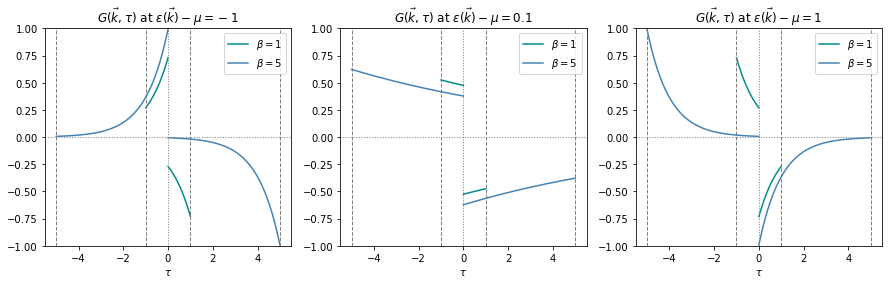

In [66]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

beta=10
def f (e,beta):
    return 1/(1+np.exp(beta*e))
def Gtau (tau, ek, beta):
    return -np.exp(-ek*tau) * ( (1-f(ek,beta))*np.heaviside(tau,1) - f(ek,beta)*np.heaviside(-tau,1) )
#def Gtau (tau, ek, beta):
#    return -np.exp(-ek*(tau-beta)) * f(ek,beta)

for ek,ax in zip([-1,0.1,1],axes):
    for beta,color in zip([1,5],['darkcyan','steelblue']):
        tau = np.linspace(-beta,-1e-10,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color, label=r"$\beta={}$".format(beta))
        tau = np.linspace(1e-10,beta,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color)
        ax.axvline(x=-beta, linestyle='--', lw=1, color='gray')
        ax.axvline(x=+beta, linestyle='--', lw=1, color='gray')
    ax.axvline(x=0, linestyle='dotted', lw=1, color='gray')
    ax.axhline(y=0, linestyle='dotted', lw=1, color='gray')
    ax.set_title(r"$G(\vec{{k}},\tau)$ at $\epsilon(\vec{{k}})-\mu={}$".format(ek))
    ax.set_ylim((-1,1))
    ax.set_xlabel(r"$\tau$")
    ax.legend()
plt.savefig("green-func-non-interacting.pdf", bbox_inches="tight")

# Unit tests for Green functions

In [25]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],float]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time (β:float, iωn:np.array, Giωn:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn)//2, len(Giωn)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) )
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn )
    return np.vectorize(f)

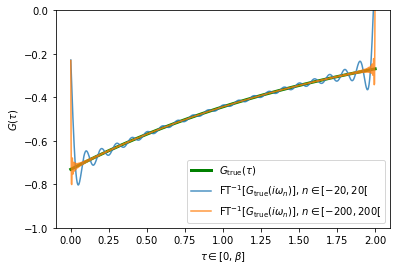

In [33]:
def test_Giωn_1 (β, iωn, ξ):
    return 1 / ( iωn - ξ )

def test_Gτ_1 (β, τ, ξ):
    return -np.exp(ξ*(β-τ)) / ( np.exp(β*ξ) + 1 )

β = 2
τ = np.linspace(0,β,1000)
dτ = τ[1] - τ[0]
ξ = 0.5

plt.plot( τ, test_Gτ_1(β,τ,ξ), label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [20,200]:
    n = np.arange(-ncut,ncut)
    iωn = 1j*ωn(β,n)
    test_Gτ_1_tr = greenmatsubara_freq_to_time(β, iωn, Giωn=test_Giωn_1(β,iωn,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut), alpha=0.8)

plt.legend()
plt.xlabel(r"$\tau \in [0,\beta]$")
plt.ylabel(r"$G(\tau)$");
#plt.savefig("green-tau-ringing.pdf", bbox_inches='tight')

In [57]:
np.linalg.norm(np.imag(test_Gτ_1_tr(τ)), ord=np.inf)

0.04179851889130457

Ok, this is bad. We need to singularize the $1/\mathrm{i}\omega_n$ term.

In [43]:
def greenmatsubara_freq_to_time_sing (β:float, iωn:np.array, Giωn_sing:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) ) -1/2
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn_sing ) -1/2
    return np.vectorize(f)

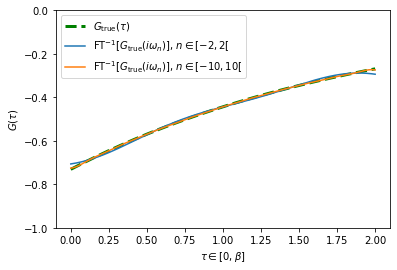

In [32]:
def test_Giωn_1_sing (β, iωn, ξ):
    return 1/( iωn - ξ ) - 1/iωn

plt.plot( τ, test_Gτ_1(β,τ,ξ), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [2, 10]:
    n = np.arange(-ncut,ncut)
    iωn = 1j*ωn(β,n)
    test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, iωn, test_Giωn_1_sing(β,iωn,ξ))
    # or with only positive frequencies :
    # n = np.arange(0,ncut)
    # iωn = 1j*ωn(β,n)
    # test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, iωn, test_Giωn_1_sing(β,iωn,ξ), halfiωn=True)
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut))

plt.legend()
plt.xlabel(r"$\tau \in [0,\beta]$")
plt.ylabel(r"$G(\tau)$");
#plt.savefig("green-tau-singularized.pdf", bbox_inches='tight')

Muuuuuuuuuuch better. Even $n=2$ works ok !

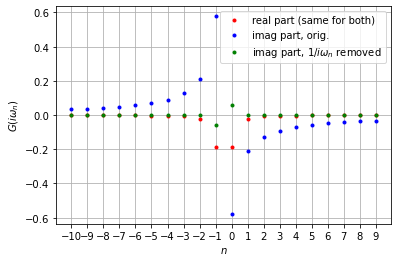

In [34]:
n = np.arange(-10,+10)
iωn = 1j*ωn(β,n)
plt.plot(n, np.real(test_Giωn_1(β,iωn,ξ)), '.', label="real part (same for both)", color='red')
plt.plot(n, np.imag(test_Giωn_1(β,iωn,ξ)), '.', label="imag part, orig.", color='blue')
plt.plot(n, np.imag(test_Giωn_1_sing(β,iωn,ξ)), '.', label=r"imag part, $1/i\omega_n$ removed", color='green')
plt.legend()
plt.xlabel("$n$")
plt.xticks(n)
plt.ylabel(r"$G(i\omega_n)$")
plt.grid();

Now let's check the other way around.

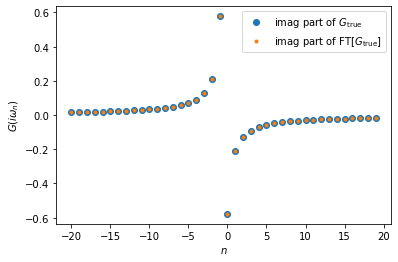

In [35]:
n = np.arange(-20,20)
iωn = 1j*ωn(β,n)
test_Giωn_1_tr = greenmatsubara_time_to_freq(β, dτ, test_Gτ_1(β,τ,ξ))
plt.plot(n, np.imag(test_Giωn_1(β,iωn,ξ)), 'o', label="imag part of $G_\operatorname{true}$")
plt.plot(n, np.imag(test_Giωn_1_tr(n)), '.', label=r"imag part of $\operatorname{FT}[G_\operatorname{true}]$")
plt.legend()
plt.xlabel("$n$")
plt.ylabel(r"$G(i\omega_n)$");

### Atomic limit

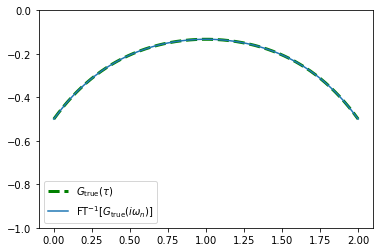

In [37]:
def Giωn_at (β, iωn, U):
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

U = 4

plt.plot( τ, Gτ_at(β,τ,U), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

n = np.arange(-10,10)
iωn = 1j*ωn(β,n)
Gτ_at_tr = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β,iωn,U)-1/iωn)
plt.plot(τ,Gτ_at_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$")

plt.legend();

Self energy $\Sigma = G_0^{-1} - G^{-1}$ in $\mathrm{i}\omega_n$ :

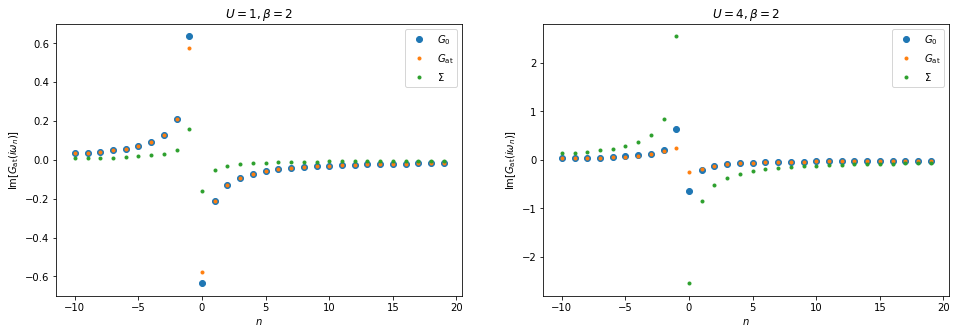

In [38]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,5))
n = np.arange(-10,20)
iωn = 1j*ωn(β,n)
for U,ax in zip([1, 4], [ax1,ax2]):
    G0 = 1/iωn
    Gat = Giωn_at(β,iωn,U)
    SelfEn = 1/G0 - 1/Gat
    ax.plot(n, np.imag(G0), 'o', label="$G_0$")
    ax.plot(n, np.imag(Gat), '.', label=r"$G_\operatorname{at}$")
    ax.plot(n, np.imag(SelfEn), '.', label=r"$\Sigma$")
    ax.legend()
    ax.set_xlabel("$n$")
    ax.set_ylabel(r"$\operatorname{Im}[ G_\operatorname{at}(i\omega_n) ]$");
    ax.set_title(r"$U={}, \beta=2$".format(U))

## On a lattice

In [156]:
# t = 1 implicitely here, for the Bethe lattice

def latt_Bethe_DoS (ϵ:float) -> float:
    return 1/(2*π) * np.sqrt(4-ϵ**2)

# with "where the sign of the imaginary part of the square root is the same as the sign of Im{z}"
def latt_Bethe_hilbert (z:float) -> float:
    inside = 0j+(z)**2-4
    sqroot = np.sqrt(inside)
    sqroot = np.real(sqroot) + 1j*np.copysign(np.imag(sqroot), np.imag(z))
    return (z-sqroot)/2

# with s=sgn(Re(z))
def latt_Bethe_hilbert (z:float) -> float:
    inside = 0j+(z+1e-40)**2-4
    s = np.sign(np.real(z+1e-40))
    return (z-s*np.sqrt(inside))/2

def latt_Bethe_R (x:float) -> float:
    if np.any(np.abs(np.real(x))>1) or np.any(np.abs(np.imag(x))>1):
        raise ValueError("the reciprocal Hilbert transform for the Bethe lattice is defined only on [-1,1]+i[-1,1]")
    return x + 1/x

Just to check if the formula for `latt_Bethe_hilbert` is right :

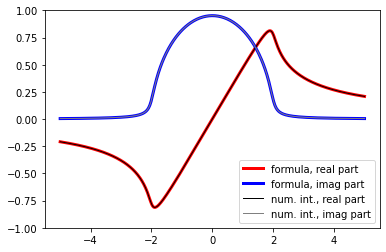

In [157]:
Z = -1 * np.linspace(-5,+5,500) - 0.1j
I = []
for z in Z:
    f = lambda e: np.sqrt(4-e**2)/(2*pi) / (z-e)
    i = 0
    delta = 0.01
#    if z < 2 and z > -2:
#        i = integrate.quad(f, a=-2, b=z-delta)[0] + integrate.quad(f, a=z+delta, b=2)[0]
#    else:
    if True:
        i  =    integrate.quad(lambda e: np.real(f(e)), a=-2, b=2)[0]
        i += 1j*integrate.quad(lambda e: np.imag(f(e)), a=-2, b=2)[0]
    I.append( i )
plt.plot(np.real(Z), np.real(latt_Bethe_hilbert(Z)), color='red', lw=3, label="formula, real part")
plt.plot(np.real(Z), np.imag(latt_Bethe_hilbert(Z)), color='blue', lw=3, label="formula, imag part")
plt.plot(np.real(Z), np.real(I), color='black', lw=1, label="num. int., real part")
plt.plot(np.real(Z), np.imag(I), color='gray', lw=1, label="num. int., imag part")
plt.ylim(-1,1)
plt.legend();

Looks like it's bijective on $\mathbb{C} \to [-1,1]+\mathrm{i} [-1,1]$.

At $U=0$ :

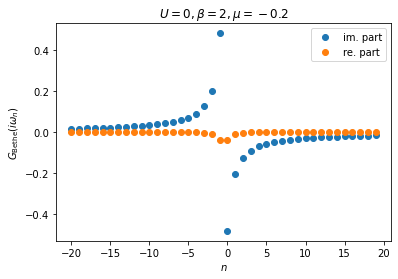

In [106]:
def G0_loc_iωn (latt_hilbert, iωn, µ):
    return latt_hilbert(iωn+µ)

β = 2
n = np.arange(-20,20)
iωn = 1j*ωn(β,n)
µ = -0.2

G0_iωn_Bethe = G0_loc_iωn(latt_Bethe_hilbert, iωn, µ)

plt.plot(n, np.imag(G0_iωn_Bethe), 'o', label='im. part')
plt.plot(n, np.real(G0_iωn_Bethe), 'o', label='re. part')
plt.xlabel("$n$")
plt.ylabel(r"$G_\operatorname{Bethe}(i\omega_n)$")
plt.legend()
plt.title(r"$U=0, \beta={}, \mu={}$".format(β,µ));

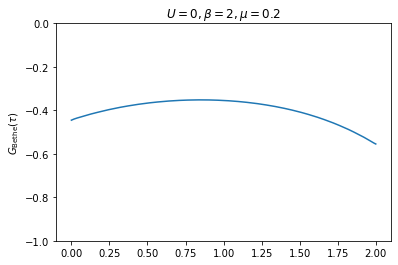

In [41]:
Gτ_Bethe = greenmatsubara_freq_to_time_sing(β, iωn, G0_iωn_Bethe-1/iωn)
τ = np.linspace(0,β,1000)
plt.plot(τ,Gτ_Bethe(τ))

plt.ylim((-1,0))
plt.ylabel(r"$G_\operatorname{Bethe}(\tau)$")
plt.title(r"$U=0, \beta={}, \mu={}$".format(β,µ));

In [121]:
def imp_Gbath_from_Gloc (R:Callable[[float],float], iωn:np.array, Gloc_iωn:np.array, µ:float) -> np.array:
    return 1 /( iωn + µ + 1/Gloc_iωn - R(Gloc_iωn) )

In [135]:
def impurity_solver_IPT (β:float, U:float, iωn:np.array, Gbath_iωn:np.array, dτ=1e-3) -> Callable[[int],float]:
    # Gbath_iωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    Gbath_shift_iωn = 1/( 1/Gbath_iωn - U/2 )
    τ = np.arange(0, β+1e-10, dτ)
    Gbath_shift_τ = greenmatsubara_freq_to_time_sing(β, iωn, Gbath_shift_iωn-1/iωn)
    Gbath_shift_τ = Gbath_shift_τ(τ)
                                   # between 0 and β integrate G(τ)^3 exp(i.ωn.τ)
    f = lambda n: U/2 + (U/2)**2 * dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gbath_shift_τ )
    return np.vectorize(f)

1.762476377327543
0.23858205529450943
0.03955264024157632
0.007469621609430741
0.0015029386399544264
0.0003107604265710339
6.497847679064569e-05
1.3648394442400228e-05
2.8720475531754186e-06


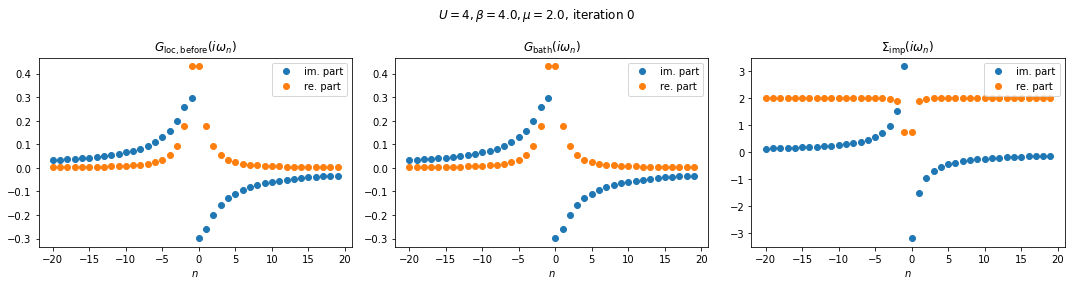

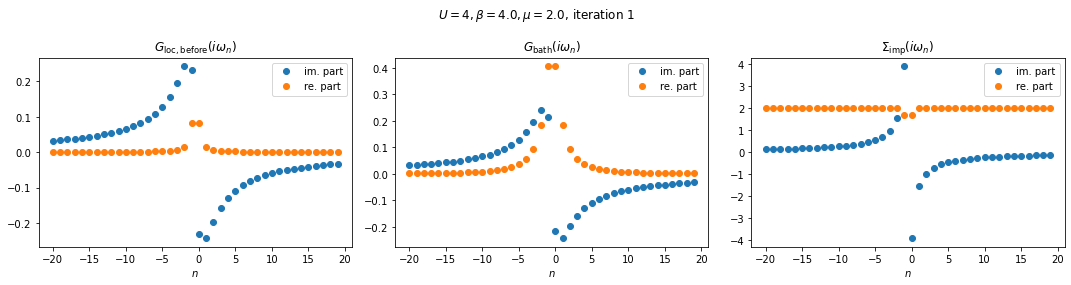

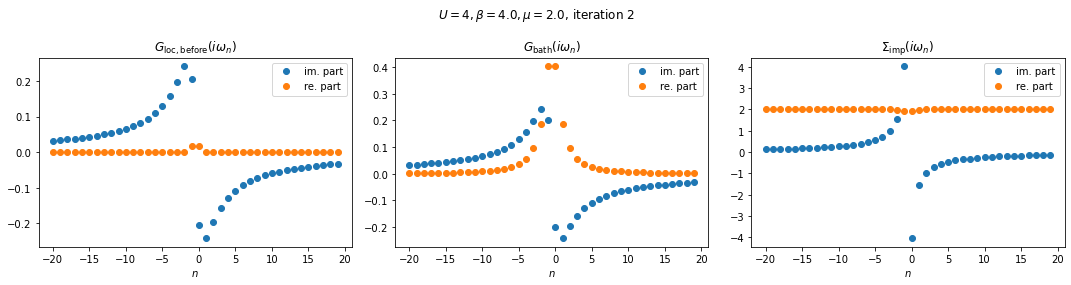

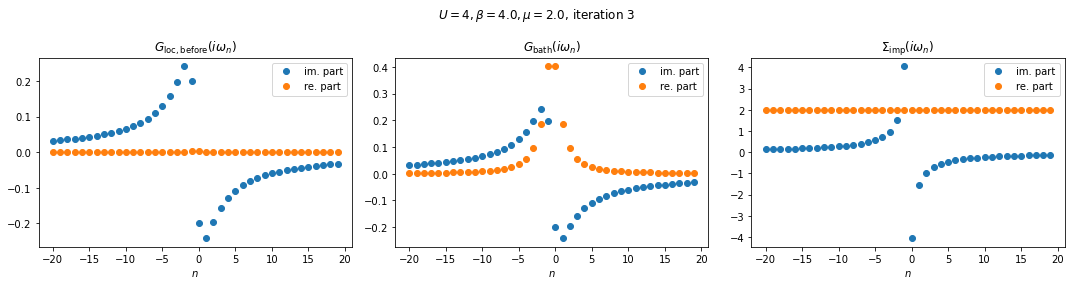

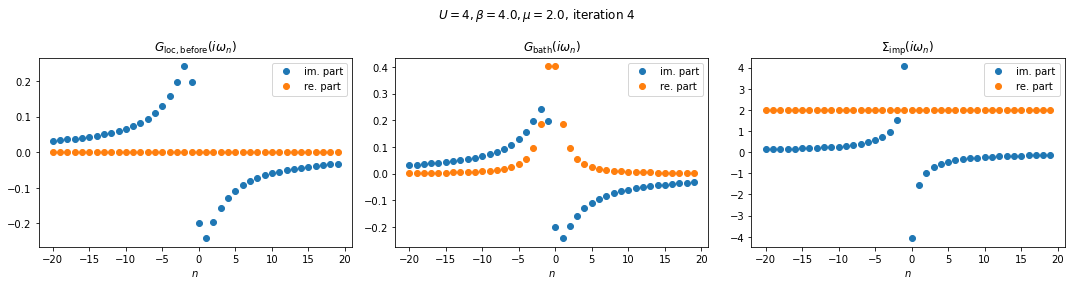

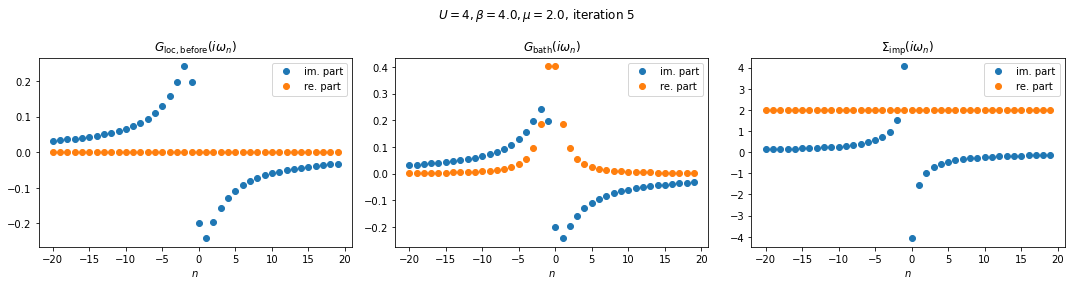

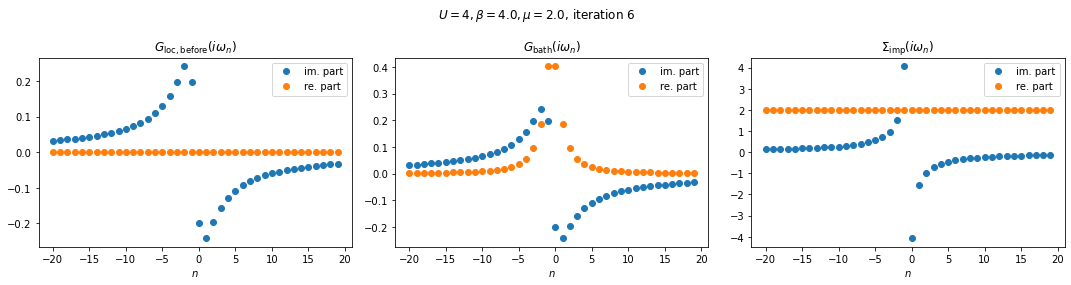

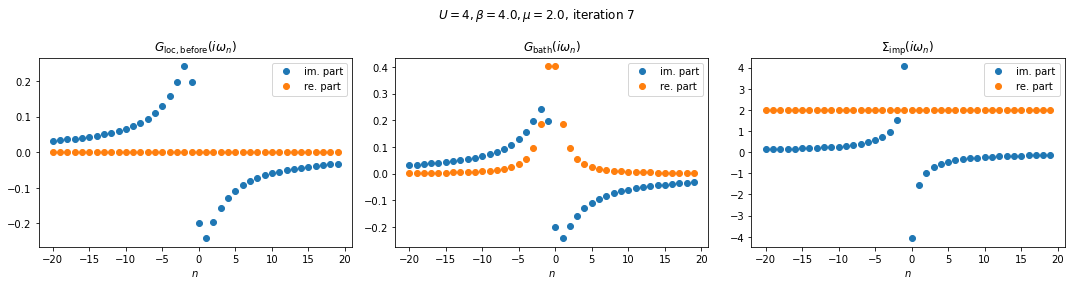

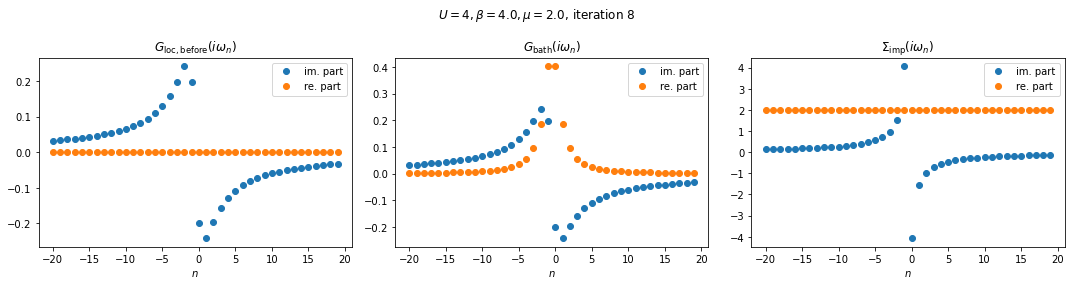

In [159]:
β = 4.
U = 4
µ = U/2
n = np.arange(-20,20)
iωn = 1j*ωn(β,n)

Gloc_iωn = G0_loc_iωn(latt_Bethe_hilbert, iωn, µ)

def plot_Giωn (ax, G_iωn, it, name="G"):
    ax.plot(n, np.imag(G_iωn), 'o', label='im. part')
    ax.plot(n, np.real(G_iωn), 'o', label='re. part')
    ax.set_xlabel("$n$")
    ax.set_title("$"+name+r"(i\omega_n)$")
    ax.legend()

γ = 0.9

for it in range(100):
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
    plot_Giωn(ax1, Gloc_iωn, it, "G_\operatorname{loc,before}")

    # DMFT loop
    Gbath_iωn = imp_Gbath_from_Gloc (latt_Bethe_R, iωn, Gloc_iωn, µ)
    plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
    Σloc_iωn = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
    Σloc_iωn = Σloc_iωn(n)
    plot_Giωn(ax3, Σloc_iωn, it, "\Sigma_\operatorname{imp}")
    Gloc_iωn_new = 1 / ( 1/Gbath_iωn - Σloc_iωn )
    # or : Gloc_iωn_new = latt_Bethe_hilbert( iωn + µ - Σloc_iωn )

    fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
    fig.tight_layout()

    norm1_diff = np.linalg.norm(Gloc_iωn-Gloc_iωn_new, ord=1)
    print(norm1_diff)
    if norm1_diff < 1e-5:
        Gloc_iωn = Gloc_iωn_new
        break
    Gloc_iωn = (1-γ) * Gloc_iωn + γ * Gloc_iωn_new